# NLP project - Analyzing billboard lyrics

This work aims at analyzing the lyrics of all __Top 100__ year billboard songs from 1957 to 2023:
1) Setup the data and some scrapping to gather more info about the songs
2) Topic modelling 
3) Song classification into the different scrapped "groups"

You can find the dataset on Kaggle ([here](https://www.kaggle.com/datasets/brianblakely/top-100-songs-and-lyrics-from-1959-to-2019)).

## 0. Setting-up our env (packages, data...)

In [1]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

import textacy
import textacy.preprocessing as tprep
import spacy
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

from sentence_transformers import SentenceTransformer

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


To use Spacy's tokernizer, it is mandatory to download first the english "model" (but can also be other language depending on the case):
```python
from spacy.cli import download
print(download('en_core_web_sm'))
```

### importing dataset

You can find this dataset on Kaggle [here](https://www.kaggle.com/datasets/brianblakely/top-100-songs-and-lyrics-from-1959-to-2019). It is composed of all __Top 100__ year billboard songs from 1957 to 2023. 

In [2]:
# Read the data into a pandas DataFrame
song_data = pd.read_csv("./data/all_songs_data_raw.csv")

### overview of the raw data

In [3]:
song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Album             6036 non-null   object 
 1   Album URL         6036 non-null   object 
 2   Artist            6500 non-null   object 
 3   Featured Artists  6384 non-null   object 
 4   Lyrics            6384 non-null   object 
 5   Media             6384 non-null   object 
 6   Rank              6500 non-null   int64  
 7   Release Date      4563 non-null   object 
 8   Song Title        6500 non-null   object 
 9   Song URL          6384 non-null   object 
 10  Writers           6384 non-null   object 
 11  Year              6500 non-null   float64
dtypes: float64(1), int64(1), object(10)
memory usage: 609.5+ KB


In [4]:
# check few rows of the data to understand the structure
song_data.sample(4)

,Album,Album URL,Artist,Featured Artists,Lyrics,Media,Rank,Release Date,Song Title,Song URL,Writers,Year
5359,Sweeter,https://genius.com/albums/Gavin-degraw/Sweeter,Gavin DeGraw,[],[Verse 1] Dreams: that's where I have to go To...,"[{'provider': 'youtube', 'start': 0, 'type': '...",60,2011-05-17,Not Over You,https://genius.com/Gavin-degraw-not-over-you-l...,"[{'api_path': '/artists/17412', 'header_image_...",2012.0
4152,Welcome II Nextasy,https://genius.com/albums/Next/Welcome-ii-nextasy,Next,[],[Hook: R.L.] You never try me Always stood rig...,[{'native_uri': 'spotify:track:3NEzjZbeSCy72Kx...,53,2000-05-16,Wifey,https://genius.com/Next-wifey-lyrics,"[{'api_path': '/artists/8450', 'header_image_u...",2000.0
3458,Portrait,https://genius.com/albums/Portrait-r-b/Portrait,Portrait,[],"(Chuck D: Here we go again) [Verse 1] Well, I...",[{'native_uri': 'spotify:track:5rIr1MOh4cWwpdl...,59,1992-10-12,Here We Go Again!,https://genius.com/Portrait-r-b-here-we-go-aga...,"[{'api_path': '/artists/998524', 'header_image...",1993.0
4273,Lil’ Romeo,https://genius.com/albums/Romeo/Lil-romeo,Lil' Romeo,"[{'api_path': '/artists/3525', 'header_image_u...",[Deejay] Hotline [Caller] Can I request a song...,[{'native_uri': 'spotify:track:0s9A4pUBLw68E76...,74,2001-04-13,My Baby,https://genius.com/Romeo-my-baby-lyrics,"[{'api_path': '/artists/673949', 'header_image...",2001.0


The main interest variable in this work is "Lyrics" one but we want to do supervised learning on it, so labels are required. In our case, the data seems rich but it is not labelled in an interesting way (except maybe year). To get some informative labels, we will webscrap (which is not very legal...) the [Genius](https://genius.com/) website to gather information regading the music tags. We did it that was as the link to the genius lyrics page is included in most observations. 

### some scrapping

This function allows to extract the data from Genius. We run it on each row.

```python
def get_genius_tag(url: str, number_tags: int = 1) -> list[str]:
    """
    WEBSCRAPING IS INVOLVED, IT'S NOT VERY LEGAL AND THE FUNCTION MIGHT BREAK IN THE FUTURE.
    get_genius_tag: Get the tags of a song from the Genius website. 
    :param url: The URL of the song on Genius.
    :param number_tags: The number of tags to get.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    finder = soup.find("div", class_="SongTags__Title-xixwg3-0 ceKRFE")
    tags = []
    if finder is None:
        return tags
    
    tag_finder = finder
    
    for i in range(number_tags):
        tag_finder = tag_finder.find_next("a")
        tags.append(tag_finder.text)
    
    return list(filter(None, tags))
```

However, it is a very time and ressource consuming process (roughly 3 hours for the whole dataset) so for this notebook, we import the processed data with the genius tags we have collected before (_cf_ `src/prep_n_scrap.py` for details). Most songs do have a tag as we can see below.

In [5]:
song_data_label = pd.read_csv("./data/all_songs_data_label.csv")
song_data_label.tags.value_counts()

tags
Pop          2711
Rock         1266
R&B          1217
Rap           637
Country       402
Non-Music      92
Name: count, dtype: int64

We exclude the useless variables and the missing data on our variables of interesst (`lyrics` and `tags`).

In [6]:
song_data_short = song_data_label[["id", "title", "artist", "tags", "lyrics", "rank", "year"]].copy()
song_data_short = song_data_short[song_data_short.tags.notnull() & song_data_short.lyrics.notnull()]

To hightlight the following processes on out textual data, we selected a sample of 5 songs:

In [7]:
song_data_short[["title", "tags", "artist"]].sample(5, random_state=1999)

,title,tags,artist
4961,Hate That I Love You,Pop,Rihanna feat. Ne-Yo
6246,Wants and Needs,Rap,Drake featuring Lil Baby
6277,All I Want for Christmas Is You,R&B,Mariah Carey
284,"Tonight My Love, Tonight",Pop,Paul Anka
4583,Southside,R&B,Lloyd feat. Ashanti


In [8]:
song_data_short.lyrics.sample(5, random_state=1999)

4961    [Intro: Rihanna & Ne-Yo] Yeah, yeah Yeah, yeah...
6246    (Six) Yeah Yeah Yeah  [Verse 1: Drake] Leave m...
6277    I don't want a lot for Christmas There is just...
284     La-la-la-la-la-la La-la-la-la-la-la Let me hol...
4583    [Verse 1: Lloyd] Tell ya daddy stop his hating...
Name: lyrics, dtype: object

## 1. Preparing our data

### exclude bracketed informations

As we can see above, lyrics in Genius often include comments about who is singing a part, if it's a chorus... So our fist mission is to exclude them as they do not convey information regarding the meaning of the song.

In [9]:
song_data_short['lyrics_wo_brack'] = song_data_short['lyrics'].apply(lambda x: re.sub(r'\[.*?\]', '', x))

song_data_short['lyrics_wo_brack'].sample(5, random_state=1999)

4961     Yeah, yeah Yeah, yeah That's how much I love ...
6246    (Six) Yeah Yeah Yeah   Leave me out the commen...
6277    I don't want a lot for Christmas There is just...
284     La-la-la-la-la-la La-la-la-la-la-la Let me hol...
4583     Tell ya daddy stop his hating Cause I be wear...
Name: lyrics_wo_brack, dtype: object

### apply a fairly common preparatory pipeline

Then, a common practice in text analysis is to normalize text and to lower the caracters. `textacy` is an excellent and easy to use library for that purpose, so let's use it. We will remove or normalize URLs, HTML tags, accents, quotation marks and punctuation.

In [10]:
preproc = tprep.make_pipeline(tprep.replace.urls,
                              tprep.remove.html_tags,
                              tprep.normalize.hyphenated_words,
                              tprep.normalize.quotation_marks,
                              tprep.normalize.unicode,
                              tprep.remove.accents,
                              tprep.remove.punctuation,
                              tprep.normalize.whitespace,
                              tprep.replace.numbers)

song_data_short['lyrics_preproc'] = song_data_short['lyrics_wo_brack'].apply(preproc).str.lower()

song_data_short['lyrics_preproc'].sample(5, random_state=1999)

4961    yeah yeah yeah yeah that s how much i love you...
6246    six yeah yeah yeah leave me out the comments l...
6277    i don t want a lot for christmas there is just...
284     la la la la la la la la la la la la let me hol...
4583    tell ya daddy stop his hating cause i be weari...
Name: lyrics_preproc, dtype: object

As shown above, the output looks way nicer.

### tokenize our lyrics

An other important step in text analysis is to tokenize the text. Tokenization is the process of splitting the text into individual words or phrases. In this case, we will use the `SpaCy` library to tokenize the lyrics.

In [11]:
# Load the English tokenizer as a pipeline (excluding the other components)
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner", "attribute_ruler", "lemmatizer"])

song_data_short['tokenized_lyrics'] = song_data_short['lyrics_preproc'].apply(lambda x: [tok.text for tok in nlp.tokenizer(x)])

song_data_short['tokenized_lyrics'].sample(5, random_state=1999)


4961    [yeah, yeah, yeah, yeah, that, s, how, much, i...
6246    [six, yeah, yeah, yeah, leave, me, out, the, c...
6277    [i, don, t, want, a, lot, for, christmas, ther...
284     [la, la, la, la, la, la, la, la, la, la, la, l...
4583    [tell, ya, daddy, stop, his, hating, cause, i,...
Name: tokenized_lyrics, dtype: object

Each token has been splitted and we obtained a list of tokens for each song. However, it still has stopwords (set of commonly used words in a language) that could biais our study, so we need to remove them.

In [12]:
# getting the stopwords for english from spacy object
stopwords_spa = nlp.Defaults.stop_words
include_stopwords={'_NUMBER_'}
stopwords_spa|= include_stopwords

song_data_short['tokenized_lyrics_stopword'] = song_data_short['lyrics_preproc'].apply(lambda x: [tok.text for tok in nlp.tokenizer(x) if tok.text.lower() not in stopwords_spa])

song_data_short['tokenized_lyrics_stopword'].sample(5, random_state=1999)

4961    [yeah, yeah, yeah, yeah, s, love, yeah, s, nee...
6246    [yeah, yeah, yeah, leave, comments, leave, non...
6277    [don, t, want, lot, christmas, thing, need, do...
284     [la, la, la, la, la, la, la, la, la, la, la, l...
4583    [tell, ya, daddy, stop, hating, cause, wearing...
Name: tokenized_lyrics_stopword, dtype: object

### excluding some outliers

As a last step, we want to remove outliers that might influence our studies. The main variable to analyze (the lyrics) is indeed highly skewed:

In [13]:
nb_tokens = song_data_short['tokenized_lyrics'].apply(len)

print(f"skewness : {skew(nb_tokens)}")

skewness : 26.927689181412013


Indeed, 125 observations (or more) have more that 1000 tokens (without stopwords). These are obviously outliers in our data that might influence our study. Arbitrarely we exclude all observations with more that 1000 tokens and those with less than 20 tokens.

In [14]:
nb_tokens.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.98, 0.99])

count      6325.000000
mean        658.690119
std        5112.511368
min           0.000000
1%           65.480000
5%          137.000000
10%         171.000000
25%         234.000000
50%         330.000000
75%         470.000000
90%         663.000000
95%         801.800000
97%         912.560000
98%        1022.000000
99%        3485.240000
max      154776.000000
Name: tokenized_lyrics, dtype: float64

In [15]:
song_data_short = song_data_short[nb_tokens.between(20, 1000)]

Fuerthermore some songs have been various times in the billboard (like the famous "All I Want for Christmas Is You" by Mariah Carey), so we exclude these duplicates (keeping only the first occurence in time):

In [16]:
song_data_short = song_data_short.sort_values("year").drop_duplicates(subset=["title", "artist"], keep="first")

So we get our cleaned lyrics data tokenized without stopwords and outliers. Our preprocessing pipeline stops here; we could have done other things to detect finer details in our lyrics (with lemmatization for instance) but it goes further than the scope of this project.

## 2. Descriptive analysis

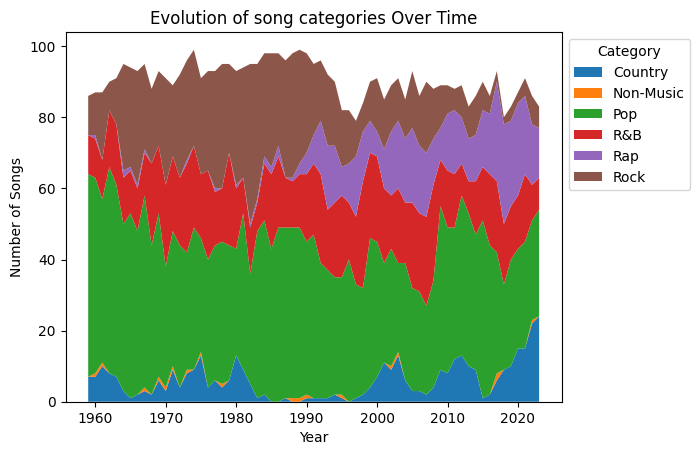

In [17]:
grouped_data = song_data_short.groupby(['year', 'tags']).size().unstack(fill_value=0)

plt.stackplot(grouped_data.index, grouped_data.values.T, labels=grouped_data.columns)
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.title('Evolution of song categories Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Category')
# Set the color palette to Viridis
sns.set_palette("viridis")

plt.show()


This graph highlights well the evolutions of the music industry: 
- Pop is the main style overall
- Rock had is "golden era" until the 80s but its share has reduced since
- Rap is growing since the 80s

N.B.: It should sum to 100 (as we have the 100 billboard for each year), but some labels could not be found. This scrapped data has also to be taken with precaution as labels might be more imprecise for old songs (Genius created in the internet era).

## 3. Topic modelling

The first thing we can do on our data is topic modelling. It is an unsupervised ML techniques that aims at creating groups of related texts within our data. Like "centroid" algorithm for quantitative data, it allow us to create groups within our corpus without having to label them first. To do some topic modelling, we will use the `gensim` library (`sklearn` also provides useful tools for topic modelling that are perfectly fine).

### step 1 - creating bag of words from our data

From our tokenized data we will create a dictionnary of all the words that are in the lyrics (after tokenization) with a unique ID.

In [18]:
# get the vocabulary
dict_gensim_text=Dictionary(song_data_short['tokenized_lyrics_stopword']) 

# filter out words that appear in less than 5 documents or more than 70% of the documents
dict_gensim_text.filter_extremes(no_below=5,no_above=0.7)

# convert the documents into bag of words (list of (token_id, token_count) tuples)
song_data_short['bow_gensim_lyrics'] = [dict_gensim_text.doc2bow(text) for text in song_data_short['tokenized_lyrics_stopword']]


print('Number of documents: %d' % song_data_short['bow_gensim_lyrics'].count())
print('Number of unique tokens: %d' % len(dict_gensim_text))

Number of documents: 5886
Number of unique tokens: 6732


Here are the tokens of the fifth song:

In [19]:
print(song_data_short['tokenized_lyrics_stopword'][120])

['stood', 'talked', 'like', 'looked', 'way', 't', 'remember', 'clothes', 'wearing', 'clothes', 'wore', 'smile', 'smiling', 'smiling', 't', 'remember', 'things', 'happen', 'time', 'happening', 'met', 'laughed', 'loved', 'knows']


And here, the bag of word representation:

In [20]:
song_data_short['bow_gensim_lyrics'][120][:50]

[(38, 1),
 (61, 1),
 (101, 1),
 (240, 1),
 (264, 1),
 (375, 1),
 (398, 1),
 (454, 1),
 (610, 2),
 (635, 1),
 (774, 1),
 (917, 1),
 (959, 2),
 (1419, 1),
 (1483, 1),
 (1601, 1),
 (1644, 1),
 (1713, 2),
 (1714, 1)]

Overall this process allow us to reprensent quantitatively our textual data. `doc2bow` generates a vector of feature. However, this vector is not semantic like embeddings would be (more like a "one hot encoding technique").

### step 2a - Compute TF-IDF for the corpus of documents and NMF factorization

TF-IDF stands for Term Frequency-Inverse Document Frequency. It's a numerical statistic used to reflect how important a word is to a document in a collection or corpus. Its value increases proportionally to the number of times a word appears in the document, but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. 

In our study, we will aim at creating 5 groups as our data only contains 5 tags with numerous observations.


In [21]:
# We initialize the tf_idf model
tfidf_gensim_text = TfidfModel([elem for elem in song_data_short['bow_gensim_lyrics']]) 

# We apply it to the bow data
song_data_short['vector_gensim_lyrics'] = tfidf_gensim_text[song_data_short['bow_gensim_lyrics']]

song_data_short['vector_gensim_lyrics'][120][:50]

[(38, 0.18299879163651192),
 (61, 0.2307080625366493),
 (101, 0.031051773593192167),
 (240, 0.045977729505301025),
 (264, 0.05488698647793115),
 (375, 0.15921855207657482),
 (398, 0.13534447685659623),
 (454, 0.1479117023059984),
 (610, 0.3616694283585011),
 (635, 0.15921855207657482),
 (774, 0.0932784845371266),
 (917, 0.26206988675686543),
 (959, 0.2637551468149587),
 (1419, 0.20772545729768224),
 (1483, 0.22834260602296302),
 (1601, 0.26676689875939036),
 (1644, 0.27379158724170255),
 (1713, 0.48491932980275043),
 (1714, 0.24895975474824386)]

As we can see above, we now have a score per token for each text. We can now apply the NMF algorithm (non probabilistic matrix descompositon) to "extract" topics from the lyrics. With that, we can get the topics and the words that are most representative of each topic (in a quite similar way as we define centroids in unsupervised ML models for quantitative data).

In [22]:
nmf_gensim_text = Nmf(song_data_short['vector_gensim_lyrics'],
                      num_topics=5,
                      id2word=dict_gensim_text,
                      kappa=0.1,eval_every=5)

### step 2b - LDA 

Latent Dirichlet Allocation (LDA), is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. We can compute it with the following command.

In [23]:
lda_gensim_text = LdaModel(corpus=song_data_short['bow_gensim_lyrics'],
                           id2word = dict_gensim_text,
                           chunksize=2000, 
                           alpha='auto',eta='auto',
                           iterations=400,num_topics=5,passes=20,eval_every=None, random_state=1999)

### description of the topics

We can see below the tokens corresponding to the automatically detected topics.

In [24]:
nmf_gensim_text.print_topics(num_topics=5,num_words=10)

[(0,
  '0.025*"la" + 0.016*"ooh" + 0.012*"oh" + 0.010*"night" + 0.009*"love" + 0.008*"little" + 0.007*"heart" + 0.007*"loving" + 0.007*"yeah" + 0.006*"sing"'),
 (1,
  '0.020*"na" + 0.012*"gon" + 0.011*"time" + 0.010*"dance" + 0.008*"believe" + 0.008*"wait" + 0.007*"babe" + 0.007*"ll" + 0.007*"woman" + 0.007*"don"'),
 (2,
  '0.007*"want" + 0.007*"yeah" + 0.006*"everybody" + 0.006*"ve" + 0.006*"think" + 0.006*"talk" + 0.006*"ll" + 0.006*"cry" + 0.006*"eyes" + 0.006*"d"'),
 (3,
  '0.012*"oh" + 0.009*"want" + 0.008*"girl" + 0.008*"need" + 0.007*"tell" + 0.006*"home" + 0.006*"little" + 0.006*"m" + 0.006*"na" + 0.006*"night"'),
 (4,
  '0.018*"baby" + 0.014*"come" + 0.013*"_" + 0.012*"love" + 0.010*"sweet" + 0.006*"number" + 0.005*"let" + 0.005*"shake" + 0.005*"wanna" + 0.005*"words"')]

In [25]:
lda_gensim_text.print_topics(num_topics=5,num_words=10)

[(0,
  '0.028*"yeah" + 0.027*"like" + 0.018*"got" + 0.015*"wanna" + 0.012*"come" + 0.012*"dance" + 0.011*"let" + 0.011*"night" + 0.010*"ah" + 0.010*"rock"'),
 (1,
  '0.033*"m" + 0.028*"_" + 0.025*"like" + 0.024*"got" + 0.017*"don" + 0.016*"ain" + 0.015*"number" + 0.015*"yeah" + 0.015*"know" + 0.010*"ya"'),
 (2,
  '0.102*"la" + 0.059*"da" + 0.028*"doo" + 0.026*"que" + 0.021*"de" + 0.018*"ba" + 0.015*"y" + 0.014*"tu" + 0.014*"lo" + 0.012*"yo"'),
 (3,
  '0.045*"love" + 0.027*"don" + 0.024*"m" + 0.023*"know" + 0.020*"ll" + 0.014*"ve" + 0.013*"time" + 0.013*"baby" + 0.012*"want" + 0.011*"like"'),
 (4,
  '0.109*"oh" + 0.061*"na" + 0.047*"baby" + 0.038*"gon" + 0.027*"yeah" + 0.026*"m" + 0.025*"ooh" + 0.020*"hey" + 0.017*"got" + 0.017*"girl"')]

### comparing topics with tags

We can now compute which song belongs to each group in order to compare that with our tags: 

In [26]:
# retrieve the topic for each document from the probability distribution to each topic
song_data_short["lyrics_topic_lda"] = song_data_short['bow_gensim_lyrics'].apply(lambda x:sorted(lda_gensim_text.get_document_topics(x), key=lambda x:x[1],reverse=False)[0][0])

In [27]:
contingency_table = pd.crosstab(song_data_short['tags'], 
                                song_data_short['lyrics_topic_lda'])

contingency_table_norm = pd.crosstab(song_data_short['tags'], 
                                     song_data_short['lyrics_topic_lda'], 
                                     normalize = 'index')

We can plot the contigency table to see what type of music is correlated with our groups. 

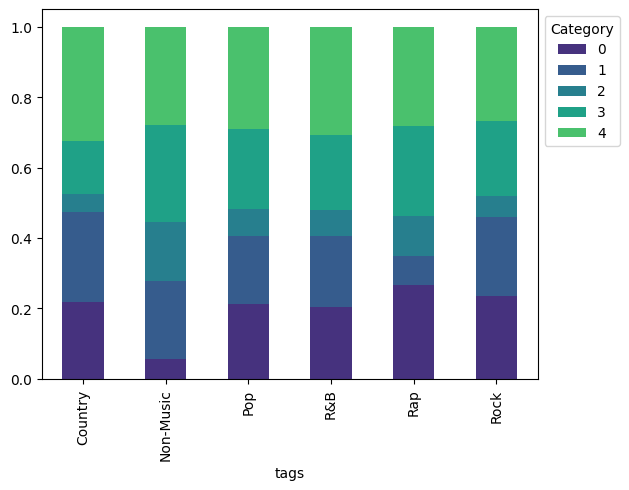

In [28]:
contingency_table_norm.plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Category')

The relationship between our two variables is actually statistically significant.

In [29]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square Statistic : {chi2}, p-value : {p}")

Chi-square Statistic : 99.1427654583608, p-value : 1.792713963084509e-12


Although our model cannot separate well the music types, it show some interesting insight and has perceived by itself some of the difference between music in terms of lyrics.

## 4. Text classification

The last part of our project aims at building a supervised predictive model to classify songs into different categories (multiclass case). We have webscrapped some tag data from Genius website that will allow us to have labels. 

We will test different models on our data and compare them:
- Support vector classifier
- AdaBoost
- XGboost

We use the preprocessed data (_cf_ section 1) and split into train and test in order to compare between model (we keep a small sample for test ~ 600 obs.). Within the train data, we will perform cross-validation process in order to select metaparameters.

The first step is to work on pure text without any semantic analysis, then we will try to compute embeddings with a BERTlike model.

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(song_data_short["lyrics_preproc"],
                                                    song_data_short['tags'], 
                                                    test_size=0.1,
                                                    random_state=1999,
                                                    stratify=song_data_short['tags'])

### classification without semantics

#### SVM model

We apply a pipeline to transform our training data each time with _tf-idf_ before fit the model in a cross validation setup. Our `grid_search` is not very complete (not so many parameters tested), but we did so in order to speed up the process.

In [33]:
pipeline_svm = Pipeline([('tfidf', TfidfVectorizer(min_df=10,ngram_range=(1,2),stop_words='english')),
                         ('svm', SVC())])

# Define the parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

# Perform grid search
grid_search = GridSearchCV(pipeline_svm, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, Y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best model for prediction
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .....................svm__C=0.1, svm__kernel=linear; total time=  14.2s
[CV] END .....................svm__C=0.1, svm__kernel=linear; total time=  14.1s
[CV] END .....................svm__C=0.1, svm__kernel=linear; total time=  14.1s
[CV] END ........................svm__C=0.1, svm__kernel=rbf; total time=  17.2s
[CV] END ........................svm__C=0.1, svm__kernel=rbf; total time=  16.7s
[CV] END ........................svm__C=0.1, svm__kernel=rbf; total time=  16.6s
[CV] END .......................svm__C=1, svm__kernel=linear; total time=  13.4s
[CV] END .......................svm__C=1, svm__kernel=linear; total time=  13.3s
[CV] END .......................svm__C=1, svm__kernel=linear; total time=  13.3s
[CV] END ..........................svm__C=1, svm__kernel=rbf; total time=  17.3s
[CV] END ..........................svm__C=1, svm__kernel=rbf; total time=  17.3s
[CV] END ..........................svm__C=1, svm_

We have here the confusion matrix

In [34]:
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Country,Pop,R&B,Rap,Rock,All
True,,,,,,
Country,11,25,2,0,1,39
Non-Music,0,2,0,0,0,2
Pop,0,201,22,3,29,255
R&B,0,85,17,8,4,114
Rap,0,22,3,30,1,56
Rock,1,99,5,0,18,123
All,12,434,49,41,53,589


In [35]:
svm_accuracy = accuracy_score(Y_test, Y_pred)

print(f"SVC best model's accuracy is: {round(svm_accuracy, 2)}")
print(f"best_params are: {best_params}")

SVC best model's accuracy is: 0.47
best_params are: {'svm__C': 1, 'svm__kernel': 'linear'}


#### XGBoost

In [37]:
le = LabelEncoder()
Y_train_le = le.fit_transform(Y_train)

pipeline_xgb = Pipeline([('tfidf', TfidfVectorizer(min_df=10,ngram_range=(1,2),stop_words='english')),
                         ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))])

param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, Y_train_le)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .....xgb__learning_rate=0.05, xgb__n_estimators=100; total time=  37.4s
[CV] END .....xgb__learning_rate=0.05, xgb__n_estimators=100; total time=  34.4s
[CV] END .....xgb__learning_rate=0.05, xgb__n_estimators=100; total time=  35.7s
[CV] END .....xgb__learning_rate=0.05, xgb__n_estimators=200; total time= 1.0min
[CV] END .....xgb__learning_rate=0.05, xgb__n_estimators=200; total time= 1.0min
[CV] END .....xgb__learning_rate=0.05, xgb__n_estimators=200; total time= 1.2min
[CV] END ......xgb__learning_rate=0.1, xgb__n_estimators=100; total time=  31.3s
[CV] END ......xgb__learning_rate=0.1, xgb__n_estimators=100; total time=  30.2s
[CV] END ......xgb__learning_rate=0.1, xgb__n_estimators=100; total time=  31.0s
[CV] END ......xgb__learning_rate=0.1, xgb__n_estimators=200; total time=  52.8s
[CV] END ......xgb__learning_rate=0.1, xgb__n_estimators=200; total time=  53.5s
[CV] END ......xgb__learning_rate=0.1, xgb__n_est

In [38]:
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Country,Pop,R&B,Rap,Rock,All
True,,,,,,
Country,7,30,0,0,2,39
Non-Music,0,2,0,0,0,2
Pop,1,234,8,7,5,255
R&B,1,77,19,12,5,114
Rap,0,21,3,32,0,56
Rock,1,114,2,0,6,123
All,10,478,32,51,18,589


In [39]:
xgb_accuracy = accuracy_score(Y_test, Y_pred)

print(f"XGBoost best model's accuracy is: {round(xgb_accuracy, 2)}")
print(f"best_params are: {best_params}")

XGBoost best model's accuracy is: 0.51
best_params are: {'xgb__learning_rate': 0.05, 'xgb__n_estimators': 100}


#### Adaboost

In [40]:

pipeline_ada = Pipeline([('tfidf', TfidfVectorizer(min_df=10,ngram_range=(1,2),stop_words='english')),
                         ('ada', AdaBoostClassifier())])

param_grid = {
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(pipeline_ada, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......ada__learning_rate=0.01, ada__n_estimators=50; total time=   3.8s
[CV] END ......ada__learning_rate=0.01, ada__n_estimators=50; total time=   3.5s
[CV] END ......ada__learning_rate=0.01, ada__n_estimators=50; total time=   3.6s
[CV] END .....ada__learning_rate=0.01, ada__n_estimators=100; total time=   6.2s
[CV] END .....ada__learning_rate=0.01, ada__n_estimators=100; total time=   6.1s
[CV] END .....ada__learning_rate=0.01, ada__n_estimators=100; total time=   5.9s
[CV] END .....ada__learning_rate=0.01, ada__n_estimators=200; total time=  10.8s
[CV] END .....ada__learning_rate=0.01, ada__n_estimators=200; total time=  10.8s
[CV] END .....ada__learning_rate=0.01, ada__n_estimators=200; total time=  10.9s
[CV] END .......ada__learning_rate=0.1, ada__n_estimators=50; total time=   3.7s
[CV] END .......ada__learning_rate=0.1, ada__n_estimators=50; total time=   3.7s
[CV] END .......ada__learning_rate=0.1, ada__n_es

In [41]:
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Pop,Rap,All
True,,,
Country,39,0,39
Non-Music,2,0,2
Pop,252,3,255
R&B,107,7,114
Rap,36,20,56
Rock,123,0,123
All,559,30,589


In [42]:
ada_accuracy = accuracy_score(Y_test, Y_pred)

print(f"Adaboost best model's accuracy is: {round(ada_accuracy, 2)}")
print(f"best_params are: {best_params}")


Adaboost best model's accuracy is: 0.46
best_params are: {'ada__learning_rate': 0.01, 'ada__n_estimators': 50}


### semantic-based classification

Various libraries exist to encode words andd sentences into a vectorial space: from the famous Word2Vec to more modern implementation relying on transformers and BERT models, even LLM can be used and tweaked for that purpose.

We will use the [`sBERT`](https://www.sbert.net/README.html) library embed our sentences. It is a relatively new library that is able to take sentence level embeddings and as a consequence can describe in a deeper way the meaning of a whole text. It is also fairly easy to implement and quite fast.

We load the model first (it is the common one for this library but more can be found [here](https://www.sbert.net/docs/pretrained_models.html)). If you use `sBERT`for the first time it will download it from the web.

In [43]:
model = SentenceTransformer("all-MiniLM-L6-v2")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### encoding the lyrics in a vectorial semantic space

In [44]:
# encoding and storing variable as a column of our main dataframe
song_data_short["sBERT_lyrics"] = song_data_short["lyrics_wo_brack"].apply(lambda x: model.encode(x))

# expanding the column into a dataframe
song_data_short_sBERT = pd.DataFrame.from_dict(dict(zip(song_data_short["sBERT_lyrics"].index, 
                                                        song_data_short["sBERT_lyrics"].values)), 
                                               orient="index")
song_data_short_sBERT["tags"] = song_data_short["tags"]

An example of encoding:

In [45]:
song_data_short["lyrics"][120]

"It seems we stood and talked like this before We looked at each other in the same way then But I can't remember where or when The clothes you're wearing are the clothes you wore The smile you are smiling you were smiling then But I can't remember where or when Some things that happen for the first time Seem to be happening again And so it seems that we have met before And laughed before And loved before But who knows where or when"

In [46]:
song_data_short["sBERT_lyrics"][120][:50]

array([-0.02488167,  0.01061767,  0.06421887,  0.08184147,  0.03567021,
        0.01955756,  0.04515632, -0.03197615,  0.086255  , -0.12256549,
        0.05114371,  0.01028266, -0.01197225, -0.00239186,  0.06221913,
       -0.03995189,  0.01014217, -0.00157251, -0.02969894, -0.00212632,
        0.06855954, -0.01122449, -0.01885332, -0.03223357,  0.01890959,
       -0.02689635,  0.02023942,  0.00801447,  0.06778741, -0.01630813,
        0.04423043, -0.04091485,  0.07488046,  0.09111501, -0.08707669,
        0.01443066,  0.04598852, -0.02119379,  0.00860582, -0.00334704,
       -0.10394209, -0.04692344, -0.05057114, -0.0177826 , -0.01346496,
        0.05180211,  0.09301236,  0.05014472,  0.01263345,  0.03074255],
      dtype=float32)

We split one again our data (the random seed allow us to keep exactly the same subsets)?

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(song_data_short_sBERT.drop(columns="tags"),
                                                    song_data_short_sBERT['tags'], 
                                                    test_size=0.1,
                                                    random_state=1999,
                                                    stratify=song_data_short_sBERT['tags'])

#### SVC

In [48]:
svc = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, verbose=2)

grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   5.6s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.3s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=   7.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   7.8s
[CV] END ..................................C=0.1, kernel=rbf; total time=   7.2s
[CV] END .................................C=1, kernel=linear; total time=   5.1s
[CV] END .................................C=1, kernel=linear; total time=   5.0s
[CV] END .................................C=1, kernel=linear; total time=   5.1s
[CV] END ....................................C=1, kernel=rbf; total time=   7.0s
[CV] END ....................................C=1, kernel=rbf; total time=   7.0s
[CV] END ....................................C=1,

In [49]:
Y_pred2 = best_model.predict(X_test)

In [50]:
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Country,Pop,R&B,Rap,Rock,All
True,,,,,,
Country,11,27,0,0,1,39
Non-Music,0,2,0,0,0,2
Pop,0,239,5,6,5,255
R&B,0,100,1,12,1,114
Rap,0,24,1,31,0,56
Rock,2,109,1,0,11,123
All,13,501,8,49,18,589


In [51]:
svm_sem_accuracy = accuracy_score(Y_test, Y_pred)

print(f"Semantic SVC best model's accuracy is: {round(svm_sem_accuracy, 3)}")

Semantic SVC best model's accuracy is: 0.497


#### XGboost

In [53]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2]
}

le = LabelEncoder()
Y_train_le = le.fit_transform(Y_train)

grid_search = GridSearchCV(xgb, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, Y_train_le)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=  35.5s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=  25.1s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=  25.0s
[CV] END ...............learning_rate=0.05, n_estimators=200; total time=  45.0s
[CV] END ...............learning_rate=0.05, n_estimators=200; total time=  45.2s
[CV] END ...............learning_rate=0.05, n_estimators=200; total time=  47.9s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  25.4s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  22.7s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  23.2s
[CV] END ................learning_rate=0.1, n_estimators=200; total time=  42.0s
[CV] END ................learning_rate=0.1, n_estimators=200; total time=  41.0s
[CV] END ................learning_rate=0.1, n_est

In [54]:
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Country,Pop,R&B,Rap,Rock,All
True,,,,,,
Country,9,29,0,0,1,39
Non-Music,0,2,0,0,0,2
Pop,1,210,15,4,25,255
R&B,0,87,14,8,5,114
Rap,0,25,3,28,0,56
Rock,2,96,3,2,20,123
All,12,449,35,42,51,589


In [55]:
xgb_sem_accuracy = accuracy_score(Y_test, Y_pred)

print(f"Semantic XGBoost best model's accuracy is: {round(xgb_sem_accuracy, 3)}")

Semantic XGBoost best model's accuracy is: 0.477


### select our final classification model

In [56]:
sumary_models = {
    'Model': ['SVM', 'AdaBoost', 'XGBoost', 'SVM semantics', 'XGBoost semantics'],
    'Accuracy': [svm_accuracy, ada_accuracy, xgb_accuracy, svm_sem_accuracy, xgb_sem_accuracy]
}

pd.DataFrame(sumary_models)

,Model,Accuracy
0,SVM,0.470289
1,AdaBoost,0.461800
2,XGBoost,0.505942
3,SVM semantics,0.497453
4,XGBoost semantics,0.477080
